In [1]:
#---------------------------------------#
# author : https://github.com/vidit1999 #
#---------------------------------------#

In [3]:
# https://www.kaggle.com/rhitazajana/spam-email

In [2]:
import re
import random
import joblib
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import defaultdict
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, make_scorer

from lightgbm import LGBMClassifier

from sklearn import set_config
from IPython.core import pylabtools

tqdm.pandas()
set_config(display='diagram')
pylabtools.figsize(16, 8)
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

In [3]:
random.seed(0)
np.random.seed(0)

In [4]:
df = pd.read_csv("../Data/Spam_classification.csv")
df

,Category,Messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5565,spam,This is the 2nd time we have tried 2 contact u...
5566,ham,Will �_ b going to esplanade fr home?
5567,ham,"Pity, * was in mood for that. So...any other s..."
5568,ham,The guy did some bitching but I acted like i'd...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5570 non-null   object
 1   Messages  5569 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
df.isnull().sum()

Category    0
Messages    1
dtype: int64

In [7]:
df[df.Messages.isnull()]

,Category,Messages
3033,ham,NaN


In [8]:
df.dropna(inplace=True)

In [9]:
df.reset_index(drop=True, inplace=True)

In [10]:
df['Category'].value_counts()

ham     4822
spam     747
Name: Category, dtype: int64

In [11]:
tag_map = defaultdict(
    lambda : "n",
    {
        'J' : "a",
        'V' : "v",
        'R' : "r",
    }
)
eng_stopwords = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

In [12]:
def clean_text(data):
    data = BeautifulSoup(data).get_text() # from html to normal text
    data = data.lower() # lowering
    data = data.encode("ascii", "ignore").decode() # non ascii chars
    data = re.sub(r'\n',' ', data) # remove new-line characters
    data = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', ' ', data) # remove html tags and entities
    data = data.replace(r'amp', ' ') # remove 'amp' word
    data = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', data, flags=re.MULTILINE) # to remove links that start with HTTP/HTTPS in the tweet
    data = re.sub(r'[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', data, flags=re.MULTILINE) # to remove other url links
    data = re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|(\w+:\/\/\S+)","",data) # mentions and hashtags
    data = re.sub(r'[^A-Za-z0-9]+', ' ', data) # special chars
    data = re.sub(r'\s+[a-zA-Z]\s+', ' ', data) # single characters
    data = re.sub(r'\^[a-zA-Z]\s+', ' ', data) # single char at first
    data = re.sub(r'[0-9]', ' ', data) # digits
    data = re.sub(r'\s+', ' ', data, flags=re.I) # multiple spaces
    return ' '.join([
        lemma.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(word_tokenize(data)) if token not in eng_stopwords
    ])

In [13]:
df.iloc[0]['Messages'], clean_text(df.iloc[0]['Messages'])

('Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'go jurong point crazy available bugis great world la buffet cine get amore wat')

(-0.5, 399.5, 199.5, -0.5)

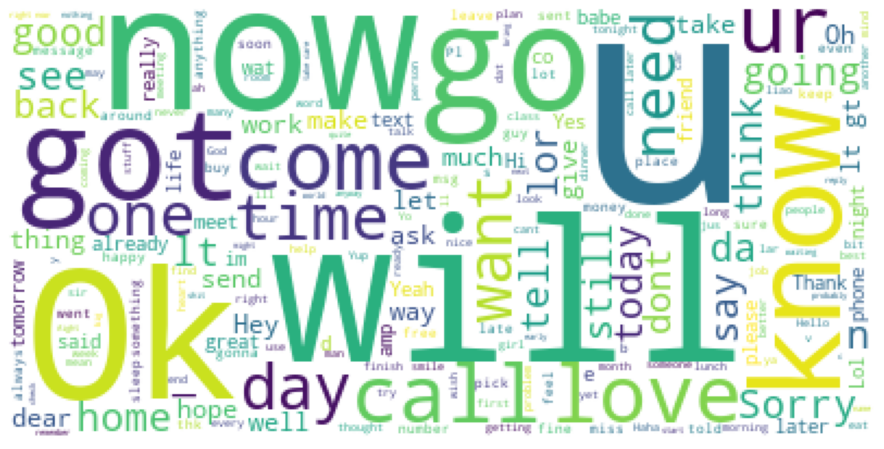

In [14]:
wc_ham = WordCloud(background_color='white').generate(' '.join(df[df['Category'] == 'ham']['Messages']))

plt.imshow(wc_ham)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

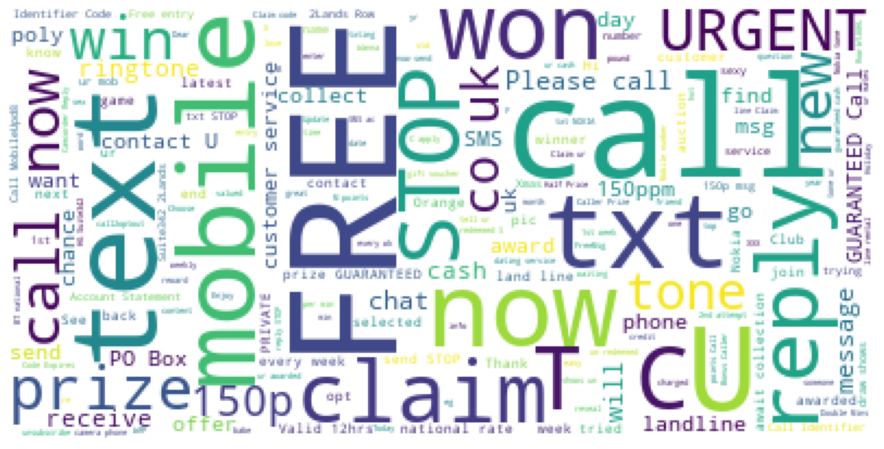

In [15]:
wc_spam = WordCloud(background_color='white').generate(' '.join(df[df['Category'] == 'spam']['Messages']))

plt.imshow(wc_spam)
plt.axis('off')

In [16]:
df.columns

Index(['Category', 'Messages'], dtype='object')

In [17]:
le = LabelEncoder()
df['cleaned_category'] = le.fit_transform(df['Category'])

In [18]:
df

,Category,Messages,cleaned_category
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
5564,spam,This is the 2nd time we have tried 2 contact u...,1
5565,ham,Will �_ b going to esplanade fr home?,0
5566,ham,"Pity, * was in mood for that. So...any other s...",0
5567,ham,The guy did some bitching but I acted like i'd...,0


In [19]:
X_train, X_test, y_train, y_test = train_test_split(df['Messages'], df['cleaned_category'])

In [20]:
pipeline = Pipeline([
    ("clean_text", FunctionTransformer(np.frompyfunc(clean_text, 1, 1))),
    ("tfidf", TfidfVectorizer()),
    ("tsvd", TruncatedSVD(n_components=100)),
    ("over_sample", RandomOverSampler()),
    ("model", LGBMClassifier()),
]).fit(X_train, y_train)

In [21]:
pipeline

Pipeline(steps=[('clean_text',
                 FunctionTransformer(func=<ufunc 'clean_text (vectorized)'>)),
                ('tfidf', TfidfVectorizer()),
                ('tsvd', TruncatedSVD(n_components=100)),
                ('over_sample', RandomOverSampler()),
                ('model', LGBMClassifier())])

In [22]:
print(classification_report(y_test, pipeline.predict(X_test), digits=4))

              precision    recall  f1-score   support

           0     0.9900    0.9818    0.9859      1208
           1     0.8872    0.9351    0.9105       185

    accuracy                         0.9756      1393
   macro avg     0.9386    0.9585    0.9482      1393
weighted avg     0.9763    0.9756    0.9759      1393



In [23]:
# base line looks good
# lets see if we can comeup with better scores

In [24]:
# we will grid search
# 1. Tfidf
#     * ngram_range [(1, 1), (1, 2)]
# 3. LGBMClassifier
#     * n_estimators [100, 200, 300, 400]

In [25]:
print(sorted(pipeline.get_params().keys()))

['clean_text', 'clean_text__accept_sparse', 'clean_text__check_inverse', 'clean_text__func', 'clean_text__inv_kw_args', 'clean_text__inverse_func', 'clean_text__kw_args', 'clean_text__validate', 'memory', 'model', 'model__boosting_type', 'model__class_weight', 'model__colsample_bytree', 'model__importance_type', 'model__learning_rate', 'model__max_depth', 'model__min_child_samples', 'model__min_child_weight', 'model__min_split_gain', 'model__n_estimators', 'model__n_jobs', 'model__num_leaves', 'model__objective', 'model__random_state', 'model__reg_alpha', 'model__reg_lambda', 'model__silent', 'model__subsample', 'model__subsample_for_bin', 'model__subsample_freq', 'over_sample', 'over_sample__random_state', 'over_sample__sampling_strategy', 'over_sample__shrinkage', 'steps', 'tfidf', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_rang

In [26]:
param_grid = dict(
    tfidf__ngram_range=[(1, 1), (1, 2)],
    model__n_estimators=[100, 200, 300],
)

print(f"Total combination count : {np.product(list(map(len, param_grid.values())))}")

Total combination count : 6


In [28]:
with joblib.parallel_backend('threading'):
    gscv = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=make_scorer(average_precision_score),
        verbose=2,
        return_train_score=True
    ).fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .model__n_estimators=100, tfidf__ngram_range=(1, 1); total time=  30.5s
[CV] END .model__n_estimators=100, tfidf__ngram_range=(1, 1); total time=  30.8s
[CV] END .model__n_estimators=100, tfidf__ngram_range=(1, 1); total time=  31.1s
[CV] END .model__n_estimators=100, tfidf__ngram_range=(1, 1); total time=  31.0s
[CV] END .model__n_estimators=100, tfidf__ngram_range=(1, 1); total time=  29.4s
[CV] END .model__n_estimators=100, tfidf__ngram_range=(1, 2); total time=  32.3s
[CV] END .model__n_estimators=100, tfidf__ngram_range=(1, 2); total time=  32.4s
[CV] END .model__n_estimators=100, tfidf__ngram_range=(1, 2); total time=  32.3s
[CV] END .model__n_estimators=100, tfidf__ngram_range=(1, 2); total time=  28.1s
[CV] END .model__n_estimators=100, tfidf__ngram_range=(1, 2); total time=  30.8s
[CV] END .model__n_estimators=200, tfidf__ngram_range=(1, 1); total time=  32.6s
[CV] END .model__n_estimators=200, tfidf__ngram_r

In [29]:
gscv.best_params_

{'model__n_estimators': 300, 'tfidf__ngram_range': (1, 1)}

In [30]:
cv_results = pd.DataFrame(gscv.cv_results_).sort_values('rank_test_score', ascending=False).reset_index(drop=True)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_tfidf__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,26.085281,1.247239,5.185832,0.433197,100,"(1, 2)","{'model__n_estimators': 100, 'tfidf__ngram_ran...",0.790115,0.788187,0.766474,...,0.795521,0.020261,6,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,27.835077,3.437564,4.477045,1.588910,300,"(1, 2)","{'model__n_estimators': 300, 'tfidf__ngram_ran...",0.789485,0.780551,0.795170,...,0.798206,0.022786,5,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,27.545829,1.474397,5.786922,0.341640,200,"(1, 2)","{'model__n_estimators': 200, 'tfidf__ngram_ran...",0.796932,0.795170,0.802835,...,0.811625,0.017961,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,25.744538,0.181903,4.891281,0.764529,100,"(1, 1)","{'model__n_estimators': 100, 'tfidf__ngram_ran...",0.797321,0.818049,0.787791,...,0.813344,0.024605,3,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,26.544128,1.152469,5.468992,0.383603,200,"(1, 1)","{'model__n_estimators': 200, 'tfidf__ngram_ran...",0.804662,0.841581,0.833585,...,0.816841,0.023615,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0


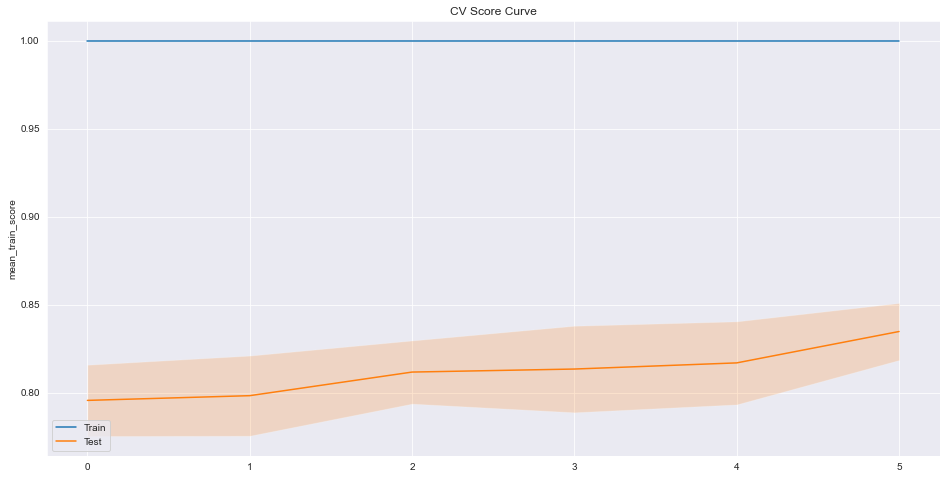

In [31]:
ax = plt.axes()

ax = sns.lineplot(x=cv_results.index, y=cv_results['mean_train_score'], label='Train')
ax.fill_between(
    cv_results.index,
    cv_results['mean_train_score'] - cv_results['std_train_score'],
    cv_results['mean_train_score'] + cv_results['std_train_score'],
    alpha=0.2
)

ax = sns.lineplot(x=cv_results.index, y=cv_results['mean_test_score'], label='Test')
ax.fill_between(
    cv_results.index,
    cv_results['mean_test_score'] - cv_results['std_test_score'],
    cv_results['mean_test_score'] + cv_results['std_test_score'],
    alpha=0.2
)

plt.title("CV Score Curve")
plt.legend()

In [32]:
best_model = gscv.best_estimator_

In [33]:
y_pred = best_model.predict(X_test)

In [34]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9900    0.9826    0.9863      1208
           1     0.8918    0.9351    0.9129       185

    accuracy                         0.9763      1393
   macro avg     0.9409    0.9589    0.9496      1393
weighted avg     0.9769    0.9763    0.9765      1393



In [35]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

Text(0.5, 1.0, 'Confusion Matrix')

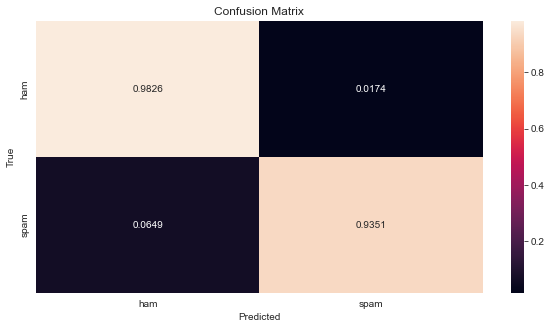

In [36]:
plt.figure(figsize=(10, 5))

ax = sns.heatmap(cm, annot=True, xticklabels=le.classes_, yticklabels=le.classes_, fmt='.4f')

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title("Confusion Matrix")